In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from glob import glob
from skimage.io import imread, imsave
import imgaug.augmenters as iaa

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style('whitegrid')

In [2]:
root_folder = '.'
data_folder = os.path.join(root_folder, 'dataset')
folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
csv_path = os.path.join(data_folder, 'HAM10000_metadata.csv')

augmented_data_folder = os.path.join(data_folder, 'Augmented_images')
balanced_csv_path = os.path.join(data_folder, 'Balanced_HAM10000_metadata.csv')

if not os.path.exists(augmented_data_folder):
    os.mkdir(augmented_data_folder)

In [3]:
data_df = pd.read_csv(csv_path)

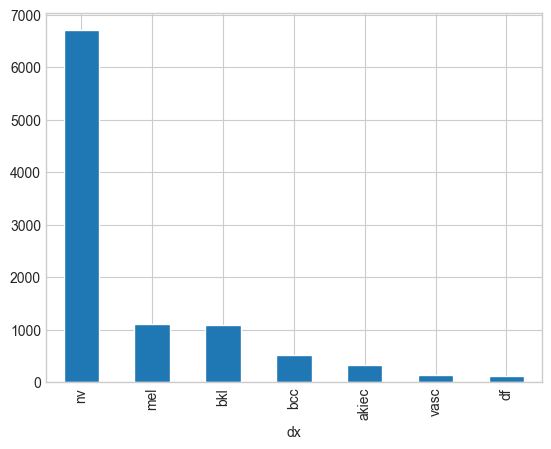

In [4]:
data_df['dx'].value_counts().plot(kind='bar')
plt.show()

In [5]:
class_counts = data_df['dx'].value_counts()
class_counts

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [6]:
jpg_files = []
for folder in folders:
    jpg_files.extend(glob(os.path.join(data_folder, folder, '*.jpg')))

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in jpg_files}

data_df['path'] = data_df['image_id'].map(imageid_path_dict.get)

In [7]:
aug_pipeline = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with probability 0.5
    iaa.Affine(rotate=(-10, 10)),  # Random rotation within -10 to 10 degrees
    iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),  # Random scaling within 90% to 110%
    iaa.Affine(shear=(-5, 5)),  # Random shear within -5 to 5 degrees
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur with a small sigma
    iaa.AdditiveGaussianNoise(scale=(0, 0.01*255)),  # Small additive Gaussian noise
    iaa.ContrastNormalization((0.9, 1.1)),  # Slightly change contrast
    iaa.CLAHE(clip_limit=(1, 2))  # Apply CLAHE with a moderate clip limit
])

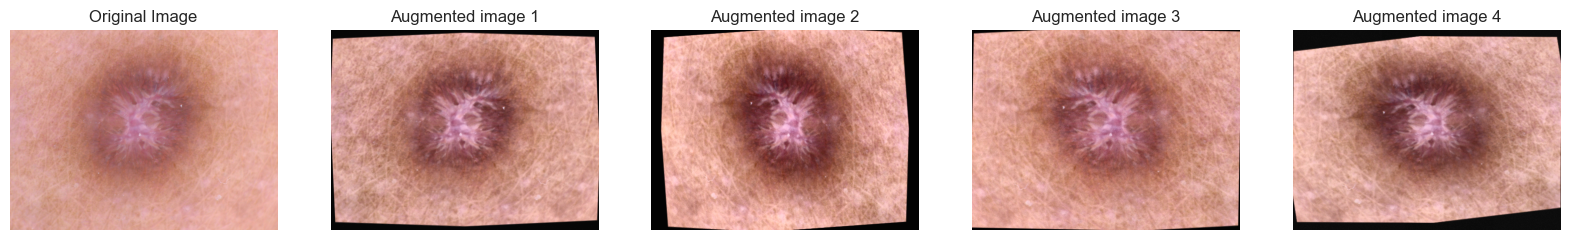

In [8]:
image = imread(os.path.join(data_folder, 'HAM10000_images_part_1', 'ISIC_0024318.jpg'))
augmented_images = [aug_pipeline(image=image) for _ in range(4)]

fig, axes = plt.subplots(1, 5, figsize=(4*5, 3))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, aug_img in enumerate(augmented_images):
    axes[i+1].imshow(aug_img)
    axes[i+1].set_title(f'Augmented image {i+1}')
    axes[i+1].axis('off')

plt.show()

In [10]:
augmented_df = pd.DataFrame(columns=data_df.columns)
count = 1500

for label in class_counts.index:
    class_subset = data_df[data_df['dx'] == label]
    if len(class_subset) < count:
        n_augmentations = count - len(class_subset)
        original_samples = class_subset.sample(n=n_augmentations, replace=True, random_state=42)
        augmented_samples = []
        
        for i, sample in original_samples.iterrows():
            img_path = sample['path']
            img = imread(img_path)
            augmented_image = aug_pipeline(image=img)

            augmented_image_name = f'{label}_augmented_{i}'
            augmented_image_path = os.path.join(augmented_data_folder, f'{augmented_image_name}.jpg')
            imsave(augmented_image_path, augmented_image)

            augmented_sample = sample.copy()
            augmented_sample['image_id'] = augmented_image_name
            augmented_sample['path'] = augmented_image_path
            augmented_samples.append(augmented_sample)

        tmp_df = pd.DataFrame(augmented_samples)
        augmented_df = pd.concat([tmp_df, augmented_df], ignore_index=True)
    else:
        n_deletions = len(class_subset) - count
        rows_to_remove = class_subset.sample(n=n_deletions, random_state=42)
        data_df = data_df.drop(rows_to_remove.index)

In [11]:
data_df = pd.concat([augmented_df, data_df], ignore_index=True)
class_counts = data_df['dx'].value_counts()
class_counts

dx
df       1500
vasc     1500
akiec    1500
bcc      1500
bkl      1500
mel      1500
nv       1500
Name: count, dtype: int64

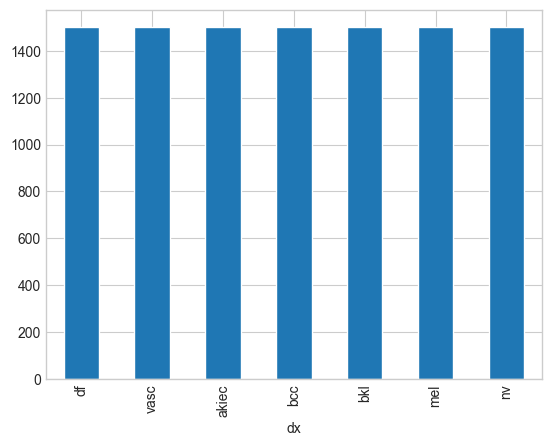

In [12]:
data_df['dx'].value_counts().plot(kind='bar')
plt.show()

In [13]:
data_df.drop(["path"], axis=1, inplace=True)
data_df.to_csv(balanced_csv_path, index=False)